<h1><center>Case Study 3:</center></h1>
<h2><center>Spam Classifier, Bayes and Clustering</center></h2>
<h3>Authors:</h3>
Joaquin Dominguez <br>
Richard Kim <br>

In [1]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

### Importing/Merging from local folder

- The path must contain all folders with emails
- Folders must have 'ham' or 'spam' in its name, and the rest of the directory must not include 'ham'
- If 'ham' is included in a spam folder's directory, spam emails may labeled 'ham' later on

In [2]:
import os

folders_path = '/home/joaquindominguez/Documents/QTW/case_studies/QTW_CaseStudy/Case Study 3/Data'

file_list = []
for root, dirs, files in os.walk(folders_path, topdown=False):
    for name in files:
        tmp = os.path.join(root,name)
        file_list.append(tmp)
    for item in dirs:
        print(item)

spam_2
easy_ham_2
easy_ham
hard_ham
spam


In [3]:
# Total number of files
len(file_list)

9353

### Parsing Emails: Text vs Multipart

- Email messages are parsed into 1 of 2 arrays, text emails and multipart emails
- Content types (e.g. text) and labels (e.g. spam) are saved in separate arrays for each category (text vs multipart)
- Directories are saved as unique IDs
- Messages with multipart content types that **DID NOT contain content types for each of its parts** were treated like single texts

In [4]:
# All-in-One
import email

text_list = []

messages_list = []
type_list = []
labels = []

uniq_mult_list = []
mult_list = []

mult_messages_list = []
mult_type_list = []
mult_labels = []

for i in range(len(file_list)):
    with open(file_list[i],'r',encoding='latin1') as f:        
        message = email.message_from_file(f)
        body = message.get_payload()
        content_type = message.get_content_type()
        
        if 'text' in content_type: 
            text_list.append(file_list[i])
            messages_list.append(body)
            if 'ham' in file_list[i]:
                labels.append(0)
            else: 
                labels.append(1)
            type_list.append(content_type)
        elif 'mult' in content_type: 
            uniq_mult_list.append(file_list[i])
            if 'text' in body:
                mult_list.append(file_list[i])
                mult_messages_list.append(body)
                mult_type_list.append(content_type)
                if 'ham' in file_list[i]:
                    mult_labels.append(0)
                else: 
                    mult_labels.append(1)
            else: 
                for j in body: 
                    if 'text' in j.get_content_type(): 
                        mult_list.append(file_list[i])
                        mult_messages_list.append(j.get_payload())
                        mult_type_list.append(j.get_content_type())
                        if 'ham' in file_list[i]:
                            mult_labels.append(0)
                        else: 
                            mult_labels.append(1)

In [5]:
# All-in-one count of files
print('**Total Number of Files**')
print(len(file_list), '\n')

print('**Text Emails**')
print('Text Email Count:',len(text_list))
print('Messages:',len(messages_list))
print('Spam/Ham Labels:',len(labels))
print('Content Type Labels:',len(type_list), '\n')

print('**Multipart Emails**')
print('Multipart Email Count:',len(uniq_mult_list))
print('Separated Messages:',len(mult_messages_list))
print('Spam/Ham Labels:',len(mult_labels))
print('Content Type Labels:',len(mult_type_list), '\n')

**Total Number of Files**
9353 

**Text Emails**
Text Email Count: 8607
Messages: 8607
Spam/Ham Labels: 8607
Content Type Labels: 8607 

**Multipart Emails**
Multipart Email Count: 746
Separated Messages: 1034
Spam/Ham Labels: 1034
Content Type Labels: 1034 



In [6]:
import pandas as pd

text_df = pd.DataFrame({'directory':text_list,'message':messages_list,'spam1':labels,'content type':type_list})
mult_df = pd.DataFrame({'directory':mult_list,'message':mult_messages_list,'spam1':mult_labels,'content type':mult_type_list})

In [7]:
# Checking how many directories come up more than once (indicating 2+ messages from a multipart email)
dups = mult_df.groupby(mult_df['directory'],as_index=False).size()
multipart_df = pd.merge(mult_df, dups, on='directory', how='left')
test = multipart_df[multipart_df['size'] > 1]

pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_rows', None)

#print(test['message'])
sum(multipart_df['size'] > 1)

677

In [8]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')
print(multipart_df.iloc[1].head(5))

directory       /home/joaquindominguez/Documents/QTW/case_stud...
message         <html>\n<head>\n<title>Free Sizzling LTC Sales...
spam1                                                           1
content type                                            text/html
size                                                            2
Name: 1, dtype: object


In [9]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
text = ''
text_list = []
for i in range(len(multipart_df)):
    val = multipart_df.iloc[i,1]
    soup = BeautifulSoup(val,'lxml')
    text = soup.get_text().lower()
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    stop_words = stopwords.words('english')
    words_list = [w for w in text.split() if w not in stop_words]
    words_list = [lemmatizer.lemmatize(w) for w in words_list]
    words_list = [stemmer.stem(w) for w in words_list]
    text_list.append(' '.join(words_list))

/usr/lib/python3/dist-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://www.rebackee.com/cursos2/contraloria.htm
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [10]:
multipart_df['proc_text'] = text_list

In [11]:
text = ''
text_list = []
for i in range(len(text_df)):
    val = text_df.iloc[i,1]
    soup = BeautifulSoup(val,'lxml')
    text = soup.get_text().lower()
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    stop_words = stopwords.words('english')
    words_list = [w for w in text.split() if w not in stop_words]
    words_list = [lemmatizer.lemmatize(w) for w in words_list]
    words_list = [stemmer.stem(w) for w in words_list]
    text_list.append(' '.join(words_list))

/usr/lib/python3/dist-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp



" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [12]:
text_df['proc_text'] = text_list

In [13]:
coll_df = pd.concat([multipart_df, text_df], axis=0)


In [14]:
coll_df = coll_df.drop(columns = ['directory', 'message', 'size', 'content type'])

In [15]:
coll_df.tail(2)

,spam1,proc_text
8605,1,never pay retail direct synergi household crea...
8606,1,dear sir madam fed rip british govern everi ti...


In [16]:
coll_df[['spam1']].apply(pd.Series.value_counts)

,spam1
0,7075
1,2566


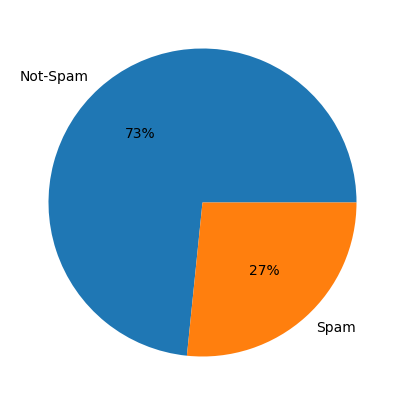

In [17]:
data = [7075/(7075+2566), 2566/(7075+2566)]
labels = ['Not-Spam', 'Spam']
plt.figure(figsize = (12,5))
plt.pie(data, labels = labels, autopct = '%.0f%%')
plt.show()

### Count Vectorizer

In [18]:
#Split

X = coll_df['proc_text']
y = coll_df['spam1']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2)

In [19]:
vect = CountVectorizer(stop_words='english')
vect.fit(X_train)

CountVectorizer(stop_words='english')

In [20]:
X_train = vect.transform(X_train).toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)

In [21]:
X_test = vect.transform(X_test).toarray()
y_test = np.array(y_test).reshape(len(y_test), 1)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

/home/joaquindominguez/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(pred, y_test)

0.9481596682218766

### TfidVectorizer

In [24]:
X = coll_df['proc_text']
y = coll_df['spam1']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2)

In [25]:
tf_vect = TfidfVectorizer(stop_words = 'english')
tf_vect.fit(X_train)
X_train = tf_vect.transform(X_train).toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)
X_test = tf_vect.transform(X_test).toarray()
y_test = np.array(y_test).reshape(len(y_test), 1)

In [26]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
accuracy_score(pred, y_test)

/home/joaquindominguez/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.8854328667703474

In [27]:
from sklearn.neighbors import NearestNeighbors
neighb = NearestNeighbors(n_neighbors=2)
nbrs = neighb.fit(X_train)
distances, indices = nbrs.kneighbors(X_train)

<function matplotlib.pyplot.show(close=None, block=None)>

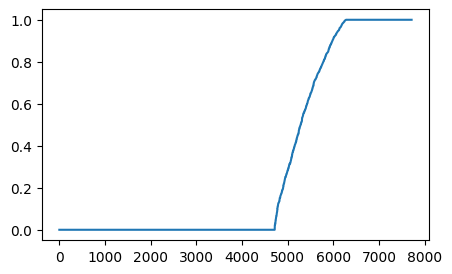

In [28]:
distances = np.sort(distances, axis = 0)
distances = distances[:, 1]
plt.rcParams['figure.figsize'] = (5,3)
plt.plot(distances)
plt.show

### DBSCAN

In [29]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps = .03, min_samples = 5).fit(X_train)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)
# )
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 33
Estimated number of noise points: 7478


### Naive Bayes

### Model

### Appendix (additional codes)

In [18]:
# Text Emails (multipart directories saved elsewhere)
import email
text_list = []
messages_list = []
type_list = []
labels = []

mult_list = []

for i in range(len(file_list)):
    with open(file_list[i],'r',encoding='latin1') as f:     
        text_list.append(file_list[i])   
        message = email.message_from_file(f)
        body = message.get_payload()
        content_type = message.get_content_type()
        
        if 'text' in content_type: 
            messages_list.append(body)
            if 'ham' in file_list[i]:
                labels.append(0)
            else: 
                labels.append(1)
            type_list.append(content_type)
        elif 'mult' in content_type: 
            mult_list.append(file_list[i])

In [19]:
# Multipart (keep parts where content types are text)
mult_messages_list = []
mult_type_list = []
mult_labels = []

for i in range(len(mult_list)):
    with open(mult_list[i],'r',encoding='latin1') as f:
        messages = email.message_from_file(f)
        body = messages.get_payload()
        content_type = messages.get_content_type()

        if 'text' in body:
            mult_messages_list.append(body)
            mult_type_list.append(content_type)
            if 'ham' in mult_list[i]:
                mult_labels.append(0)
            else: 
                mult_labels.append(1)
        else: 
            for j in body: 
                if 'text' in j.get_content_type(): 
                    mult_messages_list.append(j.get_payload())
                    mult_type_list.append(j.get_content_type())
                    if 'ham' in mult_list[i]:
                        mult_labels.append(0)
                    else: 
                        mult_labels.append(1)

### Checking Individual Emails

In [21]:
# Codeblock for looking at individual emails
filename = 'spam/00116.29e39a0064e2714681726ac28ff3fdef'

import os
with open(os.path.join('/home/joaquindominguez/Documents/QTW/case_studies/QTW_CaseStudy/Case Study 3/Data/',filename),'r',encoding='latin1') as f: 
    message = email.message_from_file(f)
    body = message.get_payload()
    print(body)

HABERDAR.COM - HABER VE MEDYA PORTALI
Artýk tüm haberleri sadece tek siteden takip edebileceksiniz. Haberdar.com açýldý!
Haber baþlýklarý, spor haberleri, teknoloji haberleri, kültür ve sanat haberleri, internet haberleri, bilim ve uzay, 
sinema, saðlýk...
Aradýðýnýz içerik http://www.haberdar.com adresinde
Sadece týklayýn ve haberdar olun

ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÓ+,ùÞµéX¬²'²Þu¼ÿ9 Íý8«yÚ¶­±©¢W\zYiÞüg­jw°êÞ~ÅDAÿÛi³ÿÿÃÿza¢xýÊ&þ¿Ú²ë­Ç¢¸×úÞ}Ê{³}ýÓÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿJ+^±Ê(¥êÿµ©d¨¥x%ËR×¬r)z¿íjYÿ+-³û(º·~à{ùÞ¶m¦ÏÿþX¬¶Ïì¢êÜyú+ïçzßåËlþX¬¶)ß£û"µë¢^¯ûZ


